In [1]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib





# Example 2: Extracellular stimulation of neurons
This is an example of **``LFPy``** running in an **``IPython notebook``**. To run through this example code and produce output, press **``<shift-Enter>``** in each code block below.

First step is to **import ``LFPy``** and other packages for analysis and plotting:

In [2]:
import LFPy
import MEAutility as mu
import numpy as np

Create some dictionarys with parameters for cell:

In [3]:
cellParameters = {
    'morphology' : 'morphologies/L5_Mainen96_LFPy.hoc',
    'tstart' : -50,
    'tstop' : 100,
    'dt' : 2**-4,
    'passive' : True,
}

Create an helper function to instantiate a **cell** object given a set of parameters:

In [4]:
def instantiate_cell(cellParameters):
    cell = LFPy.Cell(**cellParameters, delete_sections=True)
    cell.set_pos(x=0, y=0, z=0)
    cell.set_rotation(z=np.pi)

    # insert hh mechanism
    for sec in cell.allseclist:
        if 'soma' in sec.name():
            sec.insert('hh')
            break
    return cell

In [5]:
def plot_results(cell, electrode):
    figure(figsize=(12, 6))
    subplot(133)
    pcolormesh(cell.tvec, electrode.z, electrode.LFP,
               vmin=-abs(electrode.LFP).max(), vmax=abs(electrode.LFP).max())
    colorbar()
    title('LFP (mV)')

    subplot(232)
    pcolormesh(cell.t_ext, cell.zmid, np.array(cell.v_ext))
    subplot(235)
    plot(cell.tvec, cell.somav, 'k'), title('somatic voltage (mV)')

    subplot(131)
    for sec in LFPy.cell.neuron.h.allsec():
        idx = cell.get_idx(sec.name())
        plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
                np.r_[cell.zstart[idx], cell.zend[idx][-1]],
                color='k')
        if 'soma' in sec.name():
            plot(np.r_[cell.xstart[idx], cell.xend[idx][-1]],
                np.r_[cell.zstart[idx], cell.zend[idx][-1]],
                color='b', lw=5)
    plot(electrode.x, electrode.z, '.', marker='o', color='g', markersize=3)
    plot(electrode.x[stim_elec], electrode.z[stim_elec], '.', marker='o', color='r', markersize=5)
    axis([-500, 500, -400, 1200])

Instantiate a **cell** object:

In [6]:
cell1 = instantiate_cell(cellParameters)

Create an **electrode** using a commercially available design from Neuronexus:

In [7]:
probe = mu.return_mea('Neuronexus-32')

Rotate the probe and move it so that it is in the xz plane and 50 $\mu$m away from the soma:

In [8]:
probe.rotate(axis=[0, 0, 1], theta=90)
probe.move([0, 100, 0])

Create a pulse stimulation current:

In [9]:
amp = 20000
n_pulses = 2
interpulse = 10
width = 2
dt = cell1.dt
t_stop = cell1.tstop
t_start = 0
stim_elec = 15

current, t_ext = probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, t_stop=t_stop,
                                          t_start=t_start, n_pulses=n_pulses, interpulse=interpulse)

<IPython.core.display.Javascript object>


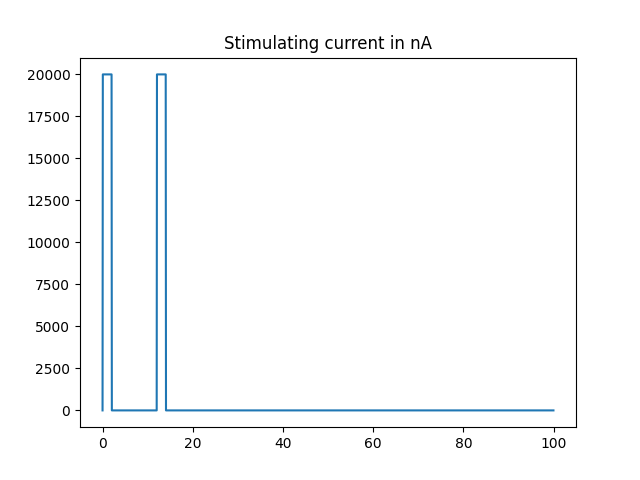

Text(0.5, 1.0, 'Stimulating current in nA')

In [10]:
figure()
plot(t_ext, current)
title("Stimulating current in nA")

Create ``LFPy`` **electrode** object:

In [11]:
electrode = LFPy.RecExtElectrode(probe=probe)

Enable extracellular stimulation for the **cell** using stimulating currents of the **electrode** object:

In [12]:
v_ext = cell1.enable_extracellular_stimulation(electrode, t_ext=t_ext) 

Run the simulation with **electrode** as input to **cell.simulate()**

In [13]:
cell1.simulate(electrode=electrode, rec_vmem=True)

Then plot the **somatic potential**, the **extracellular field** and the **LFP**
from electrode object:

<IPython.core.display.Javascript object>


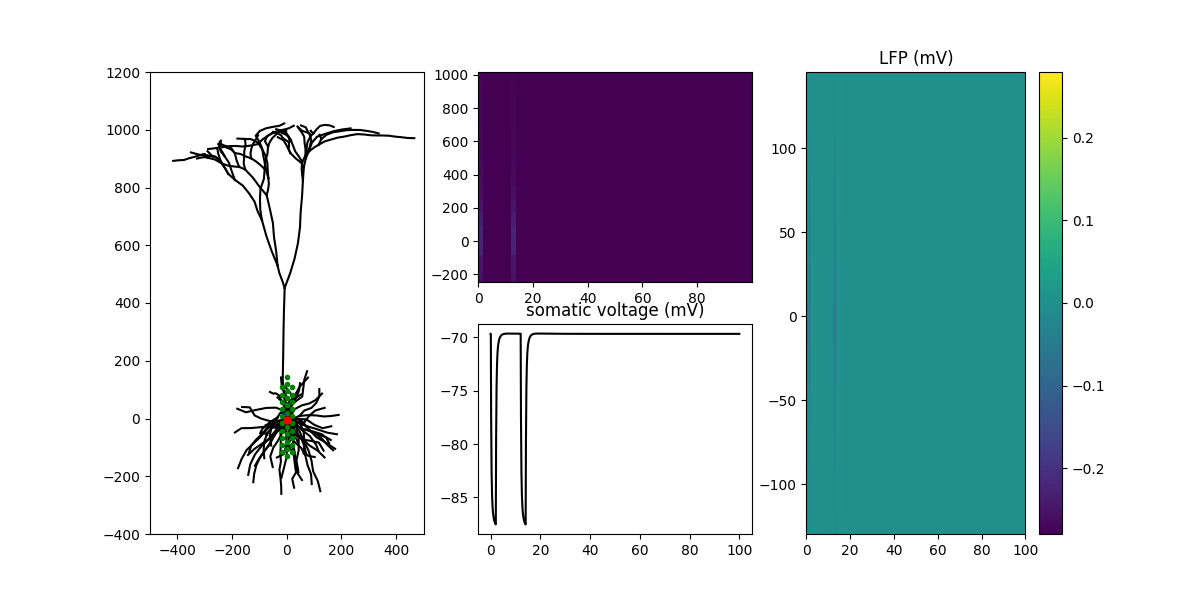

In [14]:
plot_results(cell1, electrode)

Positive pulses close to the soma location cause an hyperpolarization in the cell. Let's try something else!

In [15]:
cell2 = instantiate_cell(cellParameters)

Use the ``probe`` field in the **electrode** object created before to overwrite currents:

In [16]:
amp = -20000
n_pulses = 2
interpulse = 10
width = 2
dt = cell1.dt
t_stop = cell1.tstop
t_start = 0
stim_elec = 15

current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)

In [17]:
v_ext = cell2.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell2.simulate(electrode=electrode, rec_vmem=True)

<IPython.core.display.Javascript object>


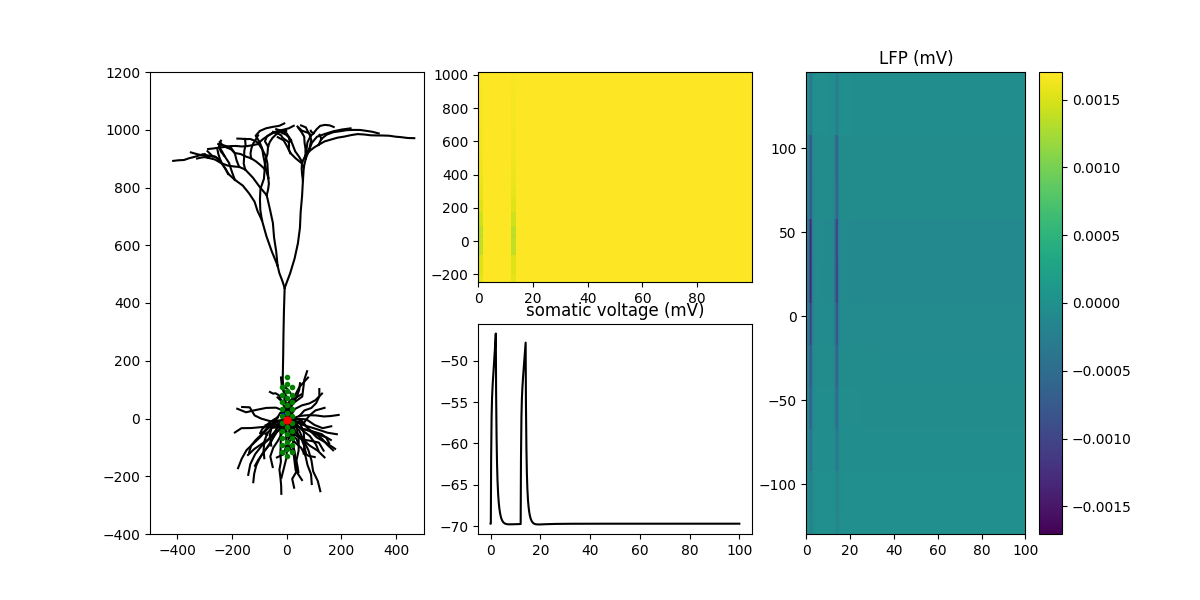

In [18]:
plot_results(cell2, electrode)

Now the membrane potential is depolarizing, but sitmulation is not strong enough to elicit an action potential.
Try to crank up the stimulation current to 50$\mu A$

In [19]:
amp = -50000
current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)
v_ext = cell2.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell2.simulate(electrode=electrode, rec_vmem=True)

<IPython.core.display.Javascript object>


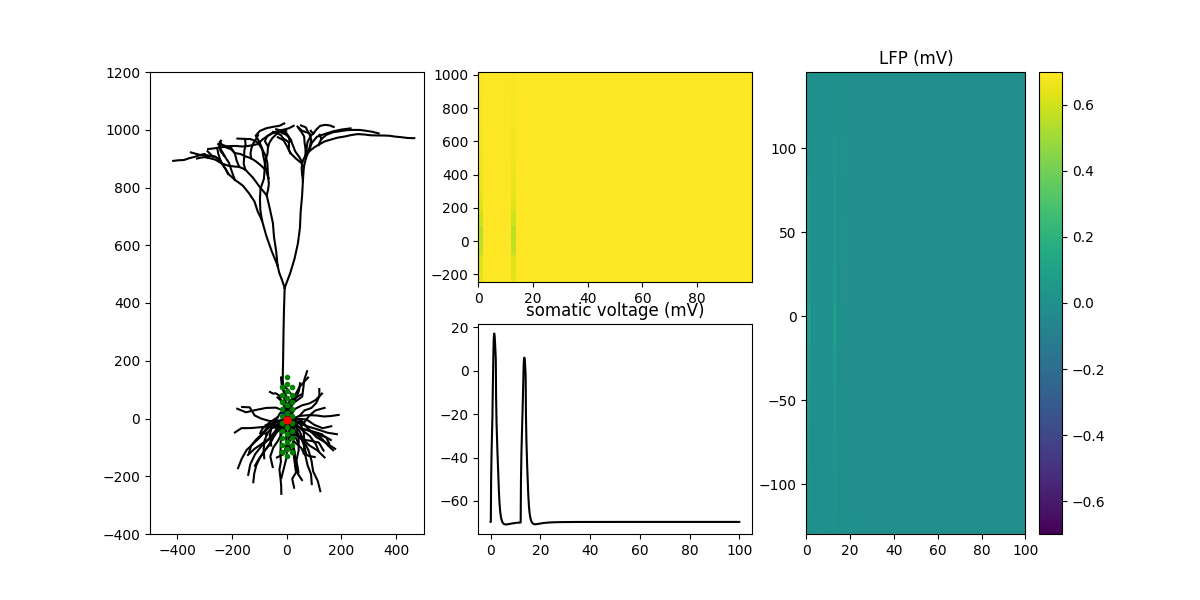

In [20]:
plot_results(cell2, electrode)

Finally we got two spikes. We can maybe get the same effect with smaller currents and higher stimulation frequencies / number of pulses / pulse width. Try to increase the pulse width:

In [21]:
amp = -20000
n_pulses = 2
interpulse = 10
width = 10
dt = cell1.dt
t_stop = cell1.tstop
t_start = 0
stim_elec = 15

current, t_ext = electrode.probe.set_current_pulses(el_id=stim_elec, amp1=amp, width1=width, dt=dt, 
                                                    t_stop=t_stop, t_start=t_start, n_pulses=n_pulses,
                                                    interpulse=interpulse)
v_ext = cell2.enable_extracellular_stimulation(electrode, t_ext=t_ext) 
cell2.simulate(electrode=electrode, rec_vmem=True)

<IPython.core.display.Javascript object>


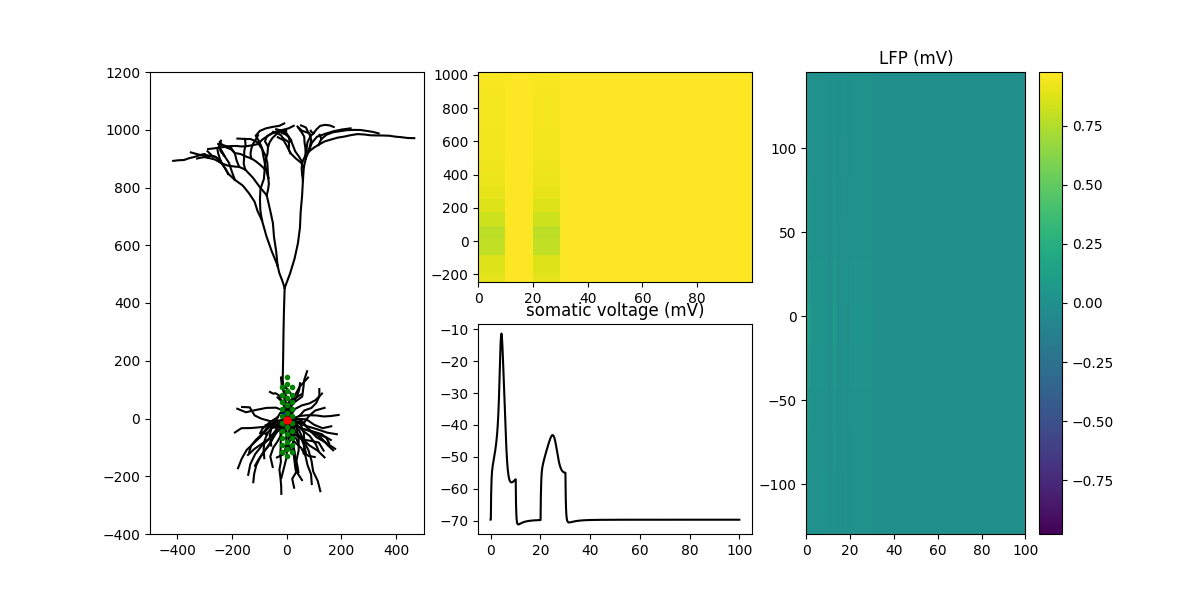

In [22]:
plot_results(cell2, electrode)